Proyecto 00. Movimiento de un satélite

Ángela Paola Vargas López

Nota1: El código está construido para que solo sea necesario modificar los valores de la PARTE 1 y la PARTE 4 para probar su funcionalidad.

En la primera parte del código se importan las librerías y elementos necesarios.

In [2]:
#PRIMERA PARTE - LIBRERÍAS
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.constants import G, M_earth, R_earth
from astropy.timeseries import TimeSeries as TS

En la segunda parte del código se definen los parámetros, los cuales se pueden modificar a gusto.

Nota2: Respecto a las unidades, se trabaja en días, kilómetros y kilogramos.

Nota3: Se utilizaron los valores predefinidos por Astropy para el radio y la masa de la Tierra, y la constante gravitacional, en vez de los que el profesor pone en el inciso de verificación.

In [4]:
#SEGUNDA PARTE - PARÁMETROS - MODIFICABLE
R = R_earth.to('km')
M = M_earth
G = G.to('km^3/kg d^2')
a = 1.30262 * R
e = 0.16561
t_p = Time('2025-03-31 00:00:00', format = 'iso', scale = 'utc')
omega = np.radians(15)

En la tercera parte del código se definen todas las funciones que se van a utilizar. KeplerF y Efunc resuelven el PRIMER PUNTO, position el SEGUNDO PUNTO, orbit el TERCER PUNTO, y quadInterpol y date el CUARTO PUNTO.

Nota4: Un posible modificable en esta parte es el parámetro N (número de datos) en las funciones orbit y date. Se establecieron valores de N adecuados para obtener resultados buenos sin necesitar demasiado tiempo de cómputo. En notas posteriores se comenta el tiempo de cómputo para diferentes valores de N.

In [6]:
#TERCERA PARTE - FUNCIONES
def KeplerF(E, t):
    '''
    Cuando esta función es igual a cero se obtiene la ecuación de Kepler.
    ---
    Argumentos:
    E: anomalía excéntrica
    t: tiempo
    '''
    F = E-e*np.sin(E)-np.sqrt(G*M/(a**3))*(t-t_p.mjd*u.d)
    return F

def Efunc(t):
    '''
    Para un tiempo t, esta función resuleve la ecuación de Kepler buscando
    la raíz de la función KeplerF con el método de bisección, retornando 
    la anomalía excéntrica E correspondiente.
    '''
    tj = t.mjd*u.d
    E_a = (np.sqrt(G*M/(a**3))*(tj-t_p.mjd*u.d)).value - np.pi
    E_b = (np.sqrt(G*M/(a**3))*(tj-t_p.mjd*u.d)).value + np.pi
    E_c = (E_a + E_b)/2.
    while np.abs(KeplerF(E_c, tj)) > 1e-15:
        E_c = (E_a + E_b)/2.
        if KeplerF(E_a, tj)*KeplerF(E_c, tj) < 0:
            E_b = E_c
        else:
            E_a = E_c
    return E_c

def position(t):
    '''
    Para un tiempo t, esta función retorna la distancia (en km) a la que
    se encuentra el satélite de la tierra, y su ángulo de traslación (en grados)
    respecto al eje horizontal.
    '''
    E = Efunc(t)
    f = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))
    r = a*(1-e**2)/(1+e*np.cos(f))
    phi = np.degrees(omega+f)*u.deg
    if phi < 0:
        phi += 360*u.deg
    return (r, phi)

def orbit():
    '''
    Esta función retorna la gráfica de la trayectoria del satélite.
    '''    
    N = 100
    period = 2*np.pi*np.sqrt((a**3)/(G*M))
    dt = period/N
    tDom = (TS(time_start = t_p, time_delta = dt, n_samples = N+1)).time
    xRang = []
    yRang = []
    for i in tDom:
        r, phi = position(i)
        xRang.append(r.value*np.cos(np.radians(phi.value)))
        yRang.append(r.value*np.sin(np.radians(phi.value)))
        
    plt.figure()
    plt.grid()
    plt.plot(xRang, yRang, '', color = 'orange', markersize = 3, label = 'Trayectoria del satélite')
    plt.plot(0, 0, 'o', color = 'blue', label = 'Foco - centro de la tierra')
    plt.xlabel(r'$x$ (km)')
    plt.ylabel(r'$y$ (km)')
    plt.title('Trayectoria del satélite respecto al centro de la Tierra')
    plt.legend(loc='lower left')
    plt.axhline(0, color='black', linewidth=.5)
    plt.axvline(0, color='black', linewidth=.5)
    plt.axis('scaled')
    plt.show()

def quadInterpol(x1, x2, x3, f1, f2, f3, x):
    '''
    Esta función interpola los puntos (x1, y1), (x2, y2) y (x3, y3)
    con una función cuadrática y retorna el valor de f para x.
    '''
    p2 = (((x-x2)*(x-x3))/((x1-x2)*(x1-x3)))*f1 +\
    (((x-x1)*(x-x3))/((x2-x1)*(x2-x3)))*f2 +\
    (((x-x1)*(x-x2))/((x3-x1)*(x3-x2)))*f3
    return p2

def date(r0):
    '''
    Para una distancia r0 respecto del centro de la tierra, esta 
    función retorna el tiempo en el que se encuentra el satélite 
    orbitando a esa distancia.
    '''
    r_max=a*(1-e**2)/(1-e)
    r_min=a*(1-e**2)/(1+e)
    if r0<r_min or r0>r_max:
        raise ValueError(f'El valor de r0 debe estar entre {r_min} y {r_min}.')
    N = 50
    half_period = np.pi*np.sqrt((a**3)/(G*M))
    dt = half_period/N
    tDom = (TS(time_start = t_p, time_delta = dt, n_samples = N+1)).time
    delta_r = np.abs(r0-(position(tDom[0]))[0])
    index = 1
    delta_r_aux = np.abs(r0-(position(tDom[index+1]))[0])
    while delta_r_aux < delta_r and index < N-1:
        delta_r = delta_r_aux
        index += 1
        delta_r_aux = np.abs(r0-(position(tDom[index+1]))[0])
    t_pol = [(tDom[index-1]).mjd, (tDom[index]).mjd, (tDom[index+1]).mjd]
    r_pol = [((position(tDom[index-1]))[0]).value, ((position(tDom[index]))[0]).value, ((position(tDom[index+1]))[0]).value]
    t0 = quadInterpol(r_pol[0], r_pol[1], r_pol[2], t_pol[0], t_pol[1], t_pol[2], r0.value)
    return Time(t0,format='mjd').iso

En la cuarta parte del código se establecen los valores de verificación para evaluar las funciones. Estos valores se pueden modificar a gusto, evitando hacerlo al momento de la evaluación.

In [8]:
#CUARTA PARTE - VALORES DE VERIFICACIÓN - MODIFICABLE
t0 = Time('2025-04-01 00:00:00', format = 'iso', scale = 'utc')
r0 = 1.5*R
#r0 = 9000*u.km

En la quinta parte del código se implementan las funciones con los valores de verificación. 

Para el PRIMER PUNTO se obtiene la anomalía excéntrica para el tiempo t0. 

In [10]:
#QUINTA PARTE - PUNTO 1
Efunc(t0)*u.deg

<Quantity 72.06282365 deg>

Para el SEGUNDO PUNTO se obtienen las coordenadas polares $r$ y $\varphi$ (respectivamente) del satélite para el tiempo t0.

In [12]:
#QUINTA PARTE - PUNTO 2
position(t0)

(<Quantity 9658.40831635 km>, <Quantity 185.5965576 deg>)

Para el TERCER PUNTO se obtiene la gráfica de la trayectoria del satélite.

Nota6: Tiempo de cómputo para N=100, t $\approx$ 6 s. Tiempo de cómputo para N=500, t $\approx$ 21 s. Tiempo de cómputo para N=1000, t $\approx$ 38 s.

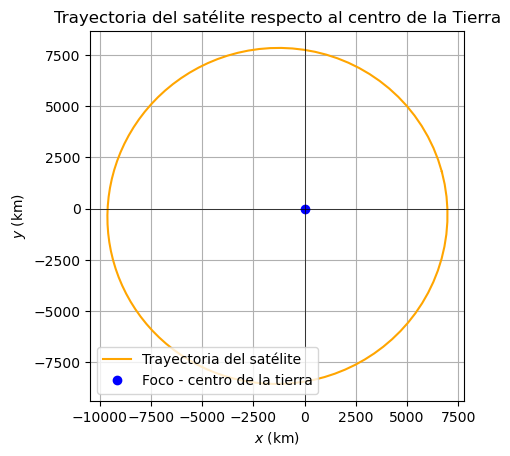

In [14]:
#QUINTA PARTE - PUNTO 3
orbit()

Para el CUARTO PUNTO se obtiene el la fecha para la cual el satélite orbita por primera vez a una distancia de r0.

Nota7: Tiempos de cómputo similares a los del punto anterior.

In [16]:
#QUINTA PARTE - PUNTO 4
date(r0)

'2025-03-31 00:53:10.021'